<a href="https://colab.research.google.com/github/ShmatArtem/TMSds/blob/main/HW22_Shmat_Artem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import DBSCAN

In [ ]:
!pip install optuna
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.4 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv('Sales.csv')
df.shape

(113036, 18)

In [ ]:
for col in df.columns:
  if df[col].nunique() < 10:
    print(f'{col}:{df[col].unique()}')

Year:[2013 2015 2014 2016 2012 2011]
Age_Group:['Youth (<25)' 'Adults (35-64)' 'Young Adults (25-34)' 'Seniors (64+)']
Customer_Gender:['M' 'F']
Country:['Canada' 'Australia' 'United States' 'Germany' 'France' 'United Kingdom']
Product_Category:['Accessories' 'Clothing' 'Bikes']


In [ ]:
df.head()

Date  Day     Month  Year  Customer_Age       Age_Group  \
0  2013-11-26   26  November  2013            19     Youth (<25)   
1  2015-11-26   26  November  2015            19     Youth (<25)   
2  2014-03-23   23     March  2014            49  Adults (35-64)   
3  2016-03-23   23     March  2016            49  Adults (35-64)   
4  2014-05-15   15       May  2014            47  Adults (35-64)   

  Customer_Gender    Country             State Product_Category Sub_Category  \
0               M     Canada  British Columbia      Accessories   Bike Racks   
1               M     Canada  British Columbia      Accessories   Bike Racks   
2               M  Australia   New South Wales      Accessories   Bike Racks   
3               M  Australia   New South Wales      Accessories   Bike Racks   
4               F  Australia   New South Wales      Accessories   Bike Racks   

               Product  Order_Quantity  Unit_Cost  Unit_Price  Profit  Cost  \
0  Hitch Rack - 4-Bike               8         45         120     590   360   
1  Hitch Rack - 4-Bike               8         45         120     590   360   
2  Hitch Rack - 4-Bike              23         45         120    1366  1035   
3  Hitch Rack - 4-Bike              20         45         120    1188   900   
4  Hitch Rack - 4-Bike               4         45         120     238   180   

   Revenue  
0      950  
1      950  
2     2401  
3     2088  
4      418

In [ ]:
df['Month'] = df['Month'].replace({'November': 11, 'January' : 1, 'March' : 3, 'May' : 5,
                     'February': 2, 'July': 7, 'August': 8, 'September':9,
                     'December': 12, 'June': 6, 'October': 10, 'April': 4})

df['Customer_Gender'] = df['Customer_Gender'].replace({'M': 1, 'F': 0})

df['Country'] = df['Country'].replace(['Canada','Australia','United States','Germany','France','United Kingdom'], [1,4,6,3,2,5])

df['Product_Category'] = df['Product_Category'].replace(['Accessories', 'Clothing', 'Bikes'], [3,2,1])

df['Age_Group'] = df['Age_Group'].replace(['Youth (<25)','Adults (35-64)', 'Young Adults (25-34)', 'Seniors (64+)'], [1,2,3,4])

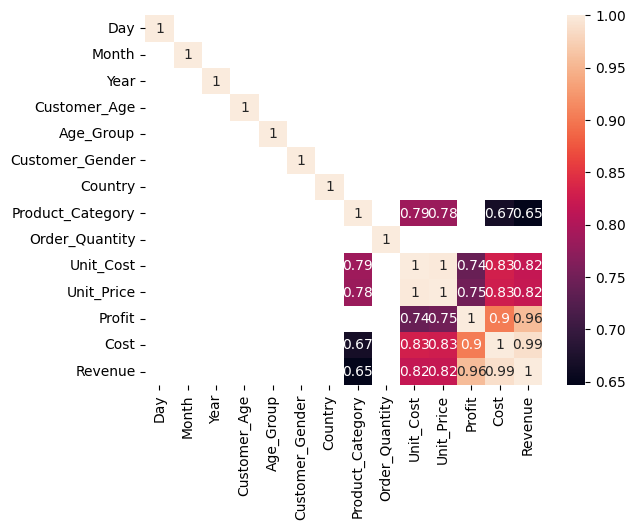

In [ ]:
cols = []
for col in df.columns:
  if type(df[col][0]) == np.int64:
    cols.append(col)

corr =df[cols].corr().abs()
sns.heatmap(data =corr[corr>0.6], annot = True)
plt.show()

Как видно колонки Unit_Cost, Unit_Cost, Profit, Cost, Revenue очень проблемные и несут в себе по сути одну и ту же инфу, но под разными углами. Думаю, это решит PCA или LDA, для них руками эту проблему исправлять не буду, а вот для обучения моделей без них стоит убрать несколько из этих фичей. Оставим лучше только колонку Order_Quantity и Profit, так как логически в ней уже заложены Revenue и Cost (P = R-C), также Unit_Cost и Unit_Revenue формируют колонки Cost и Revenue.

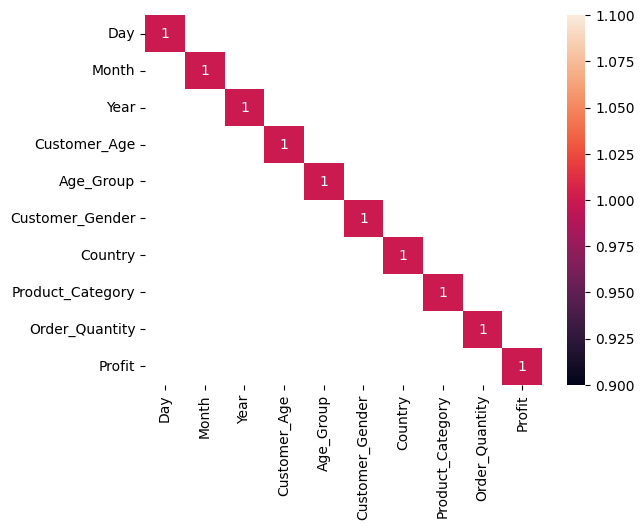

In [ ]:
df_pca = df.copy()
df = df.drop(['Unit_Cost', 'Unit_Price',	'Cost',	'Revenue'], axis =1)

cols = []
for col in df.columns:
  if type(df[col][0]) == np.int64:
    cols.append(col)

corr =df[cols].corr().abs()
sns.heatmap(data =corr[corr>0.6], annot = True)
plt.show()

Так-то лучше

Теперь уберём колонки, которые не несут для нас особого интереса и сложны для кодирования

In [ ]:
df = df.drop(['Date', 'State', 'Sub_Category', 'Product'], axis =1)
df_pca = df_pca.drop(['Date', 'State', 'Sub_Category', 'Product'], axis =1)

In [ ]:
df.describe()

Day          Month           Year   Customer_Age  \
count  113036.000000  113036.000000  113036.000000  113036.000000   
mean       15.665753       6.453024    2014.401739      35.919212   
std         8.781567       3.478198       1.272510      11.021936   
min         1.000000       1.000000    2011.000000      17.000000   
25%         8.000000       4.000000    2013.000000      28.000000   
50%        16.000000       6.000000    2014.000000      35.000000   
75%        23.000000      10.000000    2016.000000      43.000000   
max        31.000000      12.000000    2016.000000      87.000000   

           Age_Group  Customer_Gender        Country  Product_Category  \
count  113036.000000    113036.000000  113036.000000     113036.000000   
mean        2.197158         0.515871       4.145122          2.390477   
std         0.697601         0.499750       1.761553          0.835298   
min         1.000000         0.000000       1.000000          1.000000   
25%         2.000000         0.000000       3.000000          2.000000   
50%         2.000000         1.000000       4.000000          3.000000   
75%         3.000000         1.000000       6.000000          3.000000   
max         4.000000         1.000000       6.000000          3.000000   

       Order_Quantity         Profit  
count   113036.000000  113036.000000  
mean        11.901660     285.051665  
std          9.561857     453.887443  
min          1.000000     -30.000000  
25%          2.000000      29.000000  
50%         10.000000     101.000000  
75%         20.000000     358.000000  
max         32.000000   15096.000000

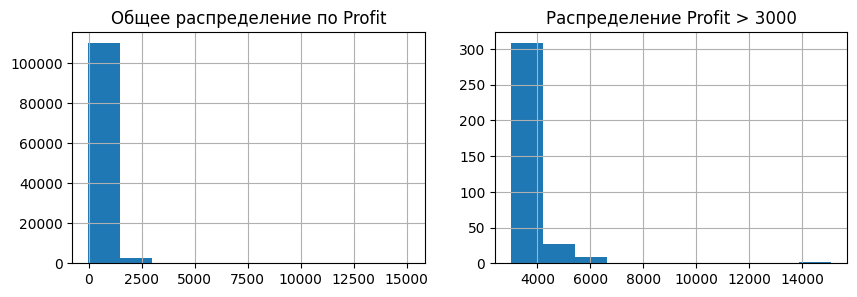

In [ ]:
plt.figure(figsize = (10,3))

plt.subplot(1,2,1)
df['Profit'].hist()
plt.title('Общее распределение по Profit')

plt.subplot(1,2,2)
df['Profit'][df.Profit > 3000].hist()
plt.title('Распределение Profit > 3000')
plt.show()

In [ ]:
print(f"Количество строк с Profit > 3000: {df['Profit'][df.Profit > 3000].count()}")

Количество строк с Profit > 3000: 346


Это похоже на выбросы, которые портят общую картину, удалим их

In [ ]:
df = df[df.Profit <3000]
df = df[df.Profit >0]

df_pca = df_pca[df_pca.Profit <3000]
df_pca = df_pca[df_pca.Profit >0]

In [ ]:
print(f"Товары первого класса: {df['Day'][(df.Product_Category == 1)].count()}")
print(f"Товары второго класса: {df['Day'][(df.Product_Category == 2)].count()}")
print(f"Товары трьтего класса: {df['Day'][(df.Product_Category == 3)].count()}")

Товары первого класса: 25638
Товары второго класса: 16450
Товары трьтего класса: 70120


Баланс классов нарушен, что может сильно повлиять на точность моделей. Попробую всё пиравнять ко второму классу, так и обучаться они будут быстрее.

In [ ]:
df_1 = df[(df.Product_Category == 1)].sample(16450)
df_2 = df[(df.Product_Category == 2)].sample(16450)
df_3 = df[(df.Product_Category == 3)].sample(16450)

df = pd.concat([df_1, df_2, df_3])
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df_1_pca = df_pca[(df_pca.Product_Category == 1)].sample(16450)
df_2_pca = df_pca[(df_pca.Product_Category == 2)].sample(16450)
df_3_pca = df_pca[(df_pca.Product_Category == 3)].sample(16450)

df_pca = pd.concat([df_1_pca, df_2_pca, df_3_pca])
df_pca = df_pca.sample(frac=1).reset_index(drop=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49350 entries, 0 to 49349
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Day               49350 non-null  int64
 1   Month             49350 non-null  int64
 2   Year              49350 non-null  int64
 3   Customer_Age      49350 non-null  int64
 4   Age_Group         49350 non-null  int64
 5   Customer_Gender   49350 non-null  int64
 6   Country           49350 non-null  int64
 7   Product_Category  49350 non-null  int64
 8   Order_Quantity    49350 non-null  int64
 9   Profit            49350 non-null  int64
dtypes: int64(10)
memory usage: 3.8 MB


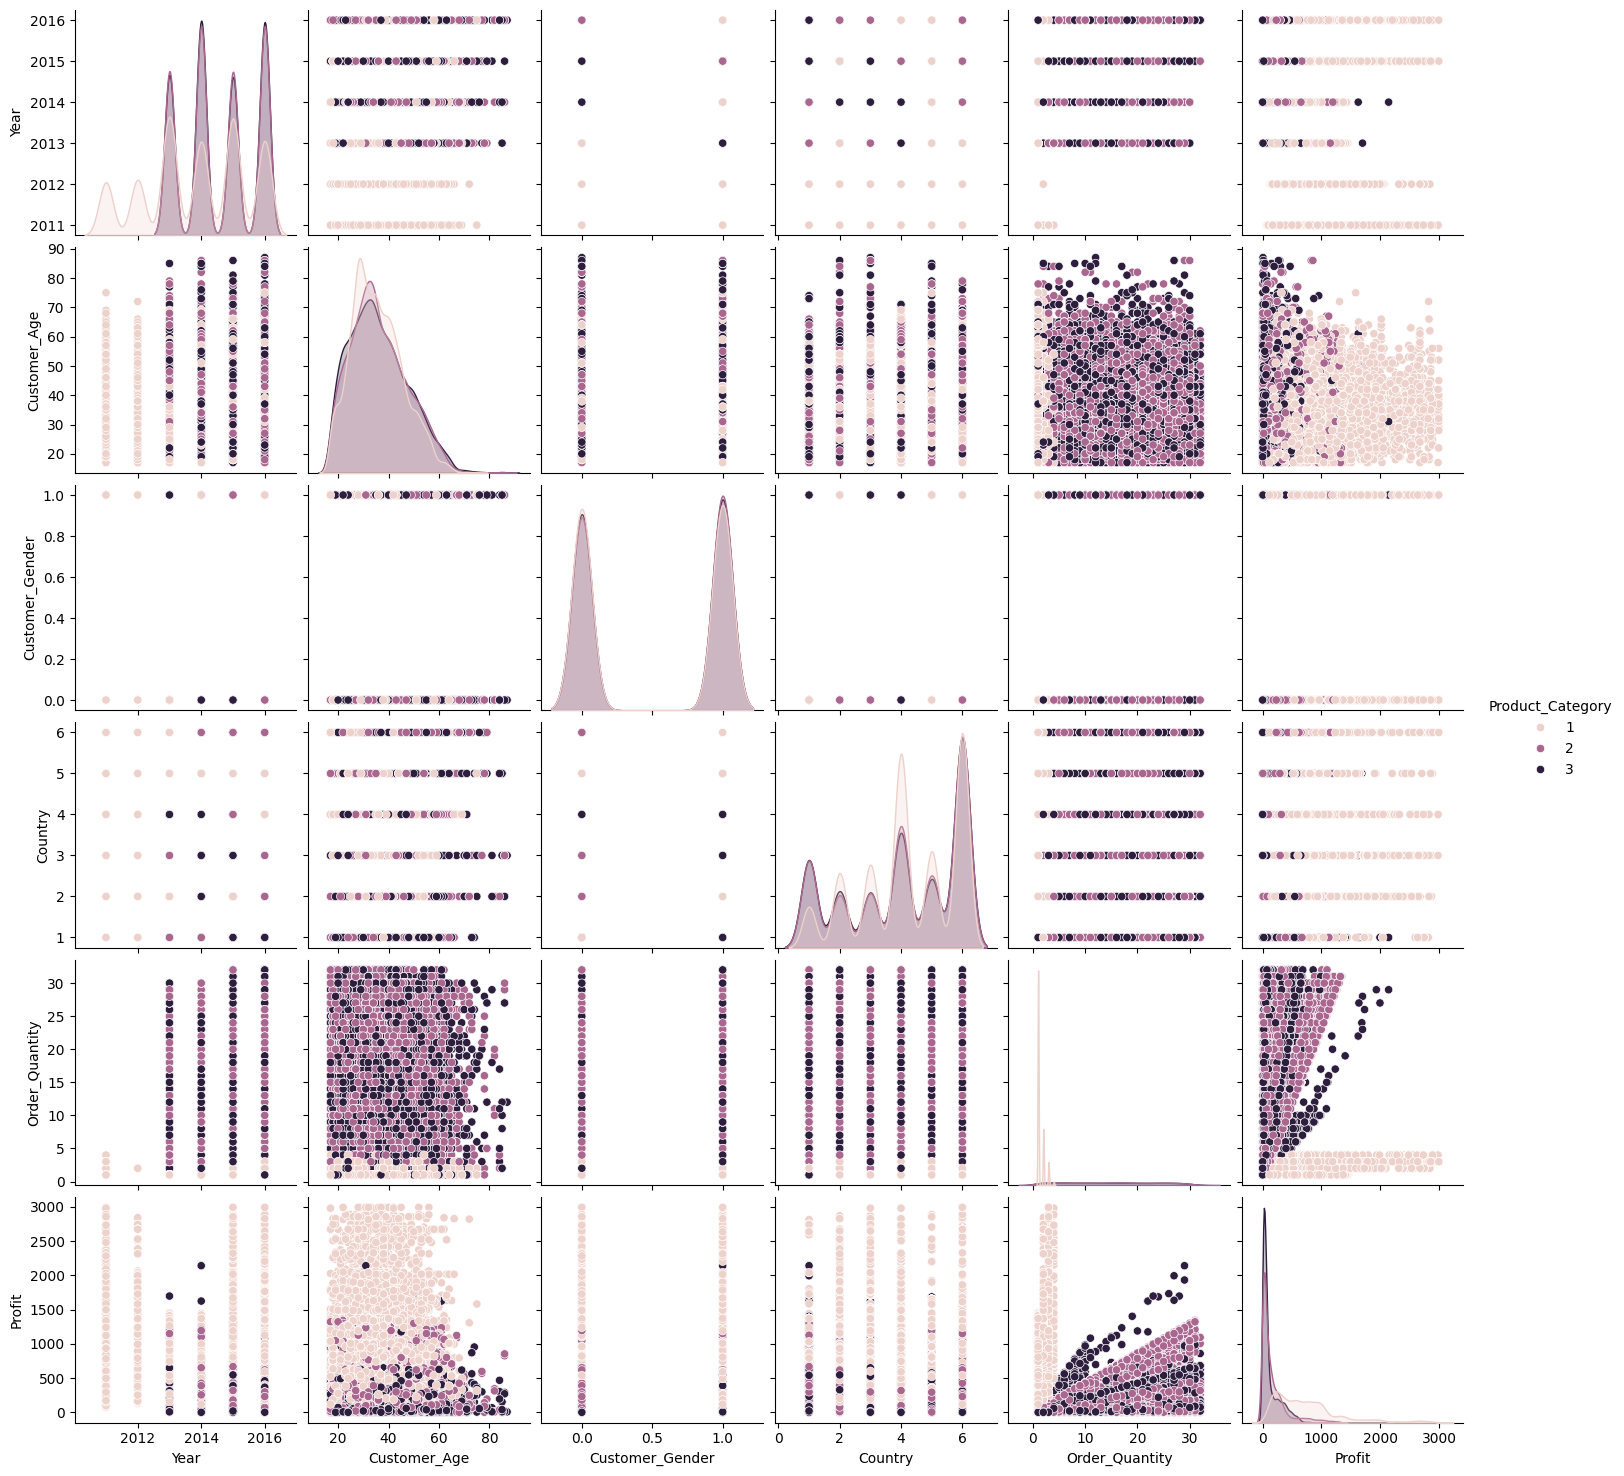

In [ ]:
cols = ['Year', 'Customer_Age', 'Customer_Gender', 'Country', 'Product_Category', 'Order_Quantity', 'Profit']
sns.pairplot(df[cols], hue="Product_Category")
sns.color_palette()
plt.show()

1. ОБУЧЕНИЕ МОДЕЛЕЙ НА ПОЛНЫХ ДАННЫХ

1.1 Регрессия (угадываем Profit)

In [ ]:
#Объявим функцию для анализа регрессии
mae_list = []
mse_list = []

def regression_report(y_test, y_pred):
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)

  mae_list.append(mae)
  mse_list.append(mse)

  print(f'MAE: {mae}')
  print(f'MSE: {mse}')

In [ ]:
# Центрируем данные, кроме целевого Product_Category
df_scaled = df.drop('Product_Category', axis =1)

scaler = StandardScaler()
df_scaled_np = scaler.fit_transform(df_scaled)

df_scaled = pd.DataFrame(df_scaled_np, columns = df_scaled.columns)

df_scaled['Product_Category'] = df['Product_Category']

In [ ]:
# Тоже самое для датасета с корреляциями
df_pca_scaled = df_pca.drop('Product_Category', axis =1)

scaler = StandardScaler()
df_pca_scaled_np = scaler.fit_transform(df_pca_scaled)

df_pca_scaled = pd.DataFrame(df_pca_scaled_np, columns = df_pca_scaled.columns)

df_pca_scaled['Product_Category'] = df_pca['Product_Category']

In [ ]:
# Разбиваем выборку
X = df_scaled.drop('Profit', axis =1)
y = df_scaled['Profit']

X_train, X_test, y_train, y_test = train_test_split(X, y)

Random Forest Regression

In [ ]:
# def objective_rf(trial):

#     n_estimators = trial.suggest_int('n_estimators', 500, 1000)
#     max_depth = trial.suggest_int('max_depth', 10, 20)

#     rf = RandomForestRegressor(max_depth=max_depth,
#                                 n_estimators = n_estimators)
#     rf.fit(X_train, y_train)

#     y_pred = rf.predict(X_test)
#     mae = mean_absolute_error(y_test, y_pred)

#     return mae

# optuna.logging.enable_default_handler() # Скрываем лог

# study = optuna.create_study()
# study.optimize(objective_rf, n_trials = 50)

# best_rf = study.best_params

In [ ]:
# rf = RandomForestRegressor(max_depth=best_rf['max_depth'],
#                            n_estimators = best_rf['n_estimators'])

# rf.fit(X_train, y_train)
# y_pred = rf.predict(X_test)

# regression_report(y_test, y_pred)

In [ ]:
rf = RandomForestRegressor(max_depth=20,
                           n_estimators = 1000)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

regression_report(y_test, y_pred)

MAE: 0.3979248381707405
MSE: 0.38663056121077843


Gradient Bossting Regressor

In [ ]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)

regression_report(y_test, y_pred)

MAE: 0.4407226001029467
MSE: 0.43682981616891176


Neural Network Regression

In [ ]:
from tensorflow import keras
import tensorflow as tf

model_NN = tf.keras.Sequential([
    tf.keras.layers.Dense(units=10, activation='relu'),
    tf.keras.layers.Dense(units=20, activation='relu'),
    tf.keras.layers.Dense(units=15, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='relu'),
    tf.keras.layers.Dense(units=5, activation='relu'),
    tf.keras.layers.Dense(units=1, activation = 'relu')
])

model_NN.compile(optimizer='adam', loss='mse')

loss = model_NN.fit(X_train, y_train, epochs = 50)

386/386 [==============================] - 1s 2ms/step
MAE: 0.6491774060720543
MSE: 0.6088865910589689


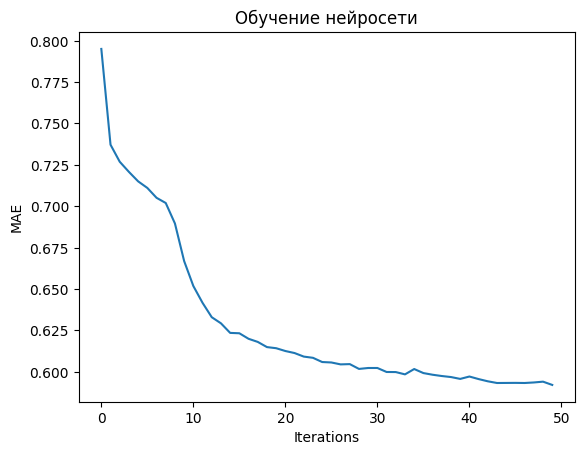

In [ ]:
y_pred = model_NN.predict(X_test)
regression_report(y_test, y_pred)

plt.plot(loss.history['loss'])
plt.title('Обучение нейросети')
plt.xlabel('Iterations')
plt.ylabel('MAE')
plt.show()

1.2 Классификация (угадываем Product_Category)

In [ ]:
# Объявим функцию для анализа классификации
accuracy_list = []
f1_list = []

def classification_report(y_test, y_pred):
  f1 = f1_score(y_test, y_pred, average = 'weighted')
  accuracy = accuracy_score(y_test, y_pred)

  accuracy_list.append(accuracy)
  f1_list.append(f1)

  print(f'Accuracy score: {accuracy}')
  print(f"F-1 score: {f1}")

  plt.title('Confusion Matrix')
  sns.heatmap(data = confusion_matrix(y_test, y_pred), annot = True, fmt = 'g')
  plt.show()

In [ ]:
X = df_scaled.drop('Product_Category', axis =1)
y = df_scaled['Product_Category']

X_train, X_test, y_train, y_test = train_test_split(X, y)

Random Forest Classification

Accuracy score: 0.8875020262603339
F-1 score: 0.8874233455663422


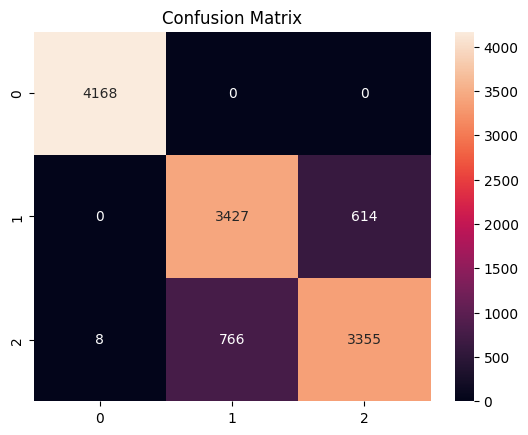

In [ ]:
rf = RandomForestClassifier(max_depth= 20,
                           n_estimators = 1000)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

classification_report(y_test, y_pred)

SVM Classification

Accuracy score: 0.6959798994974874
F-1 score: 0.6936222605405142


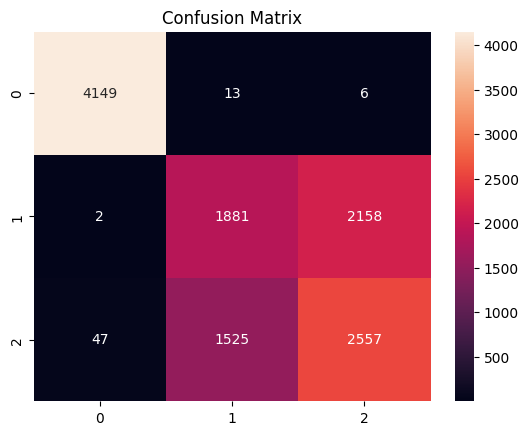

In [ ]:
svc = SVC()

svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

classification_report(y_test, y_pred)

Neural Network Classification

In [ ]:
model_nn = tf.keras.Sequential([
    keras.layers.Dense(10, activation=tf.nn.relu),
    keras.layers.Dense(20, activation=tf.nn.relu),
    keras.layers.Dense(15, activation=tf.nn.relu),
    keras.layers.Dense(8, activation=tf.nn.relu),
    keras.layers.Dense(4, activation=tf.nn.softmax)
])

loss = tf.keras.losses.SparseCategoricalCrossentropy()
model_nn.compile(optimizer = 'adam', loss = loss, metrics=['accuracy'])

history = model_nn.fit(X_test, y_test, epochs = 200)

386/386 [==============================] - 1s 2ms/step
Accuracy score: 0.8209596368941482
F-1 score: 0.8208217999971538


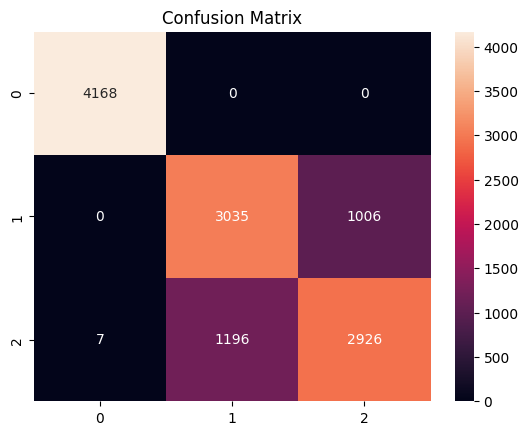

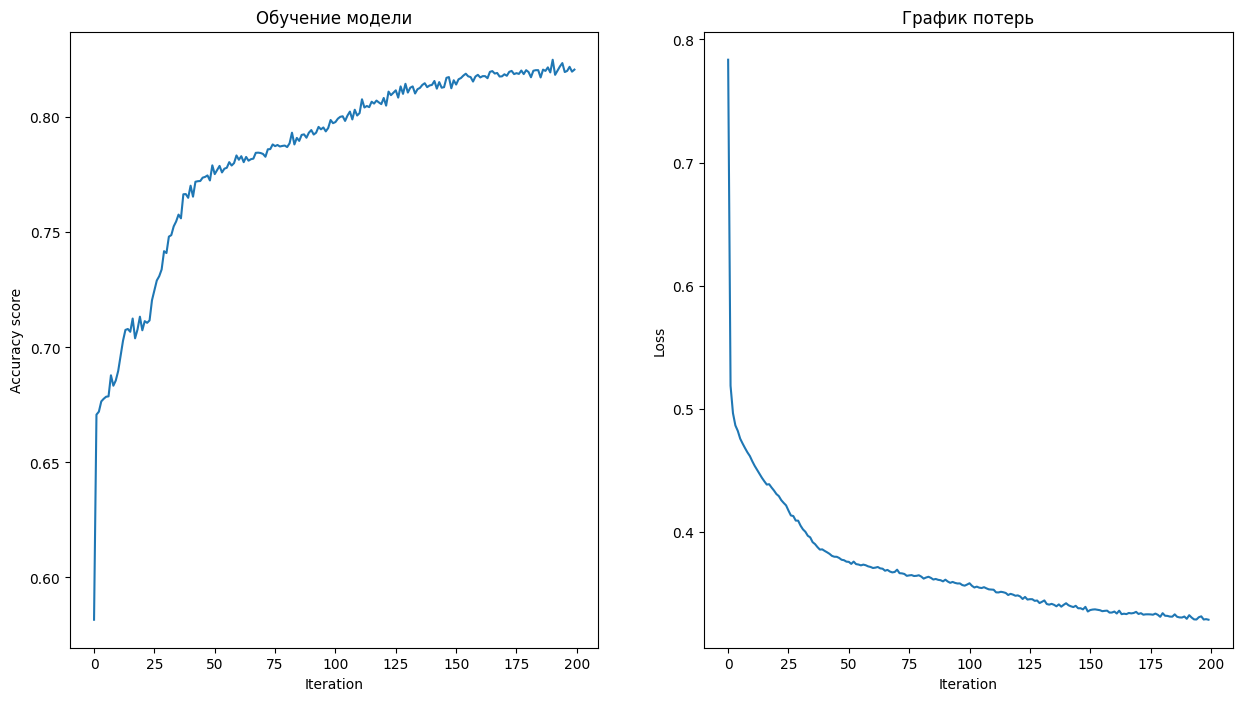

In [ ]:
y_pred = model_nn.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

classification_report(y_test, y_pred)

plt.figure(figsize = (15, 8))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"])
plt.xlabel('Iteration')
plt.ylabel('Accuracy score')
plt.title('Обучение модели')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('График потерь')

plt.show()

1.3 Кластеризация

In [ ]:
# Объявим функцию для оценки кластеризации
sil_score = []
cal_har_score = []
bould_score = []

def clustering_report(data, labels):
  sil = silhouette_score(data, labels)
  sil_score.append(sil)

  cal = calinski_harabasz_score(data, labels)
  cal_har_score.append(cal)

  bould = davies_bouldin_score(data, labels)
  bould_score.append(bould)

  print(f"Silhouette score: {sil} --- Варьируется от -1 до 1, лучше, когда больше")
  print(f"Calinski harabasz score: {cal} --- Лучше, когда больше")
  print(f"Davies bouldin score: {bould} --- Лучше, когда меньше")

K-means

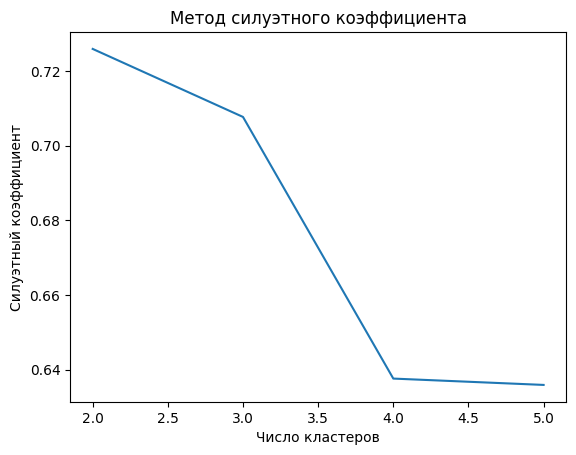

In [ ]:
silhouette_coefficients = []

for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=5, random_state=1)
    kmeans.fit(df)
    score = silhouette_score(df, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.plot(range(2, 6), silhouette_coefficients)
plt.title('Метод силуэтного коэффициента')
plt.xlabel('Число кластеров')
plt.ylabel('Силуэтный коэффициент')
plt.show()

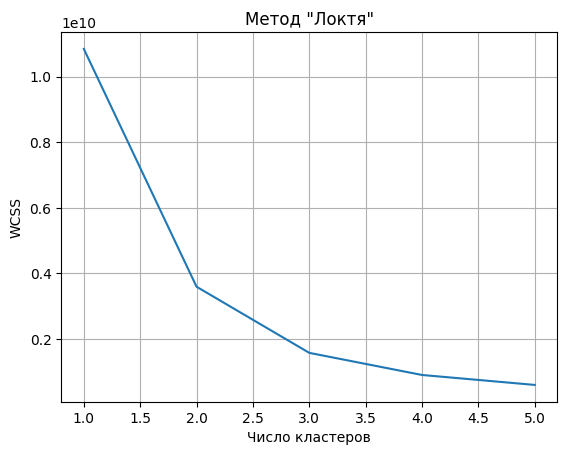

In [ ]:
wcss = []

for i in range(1, 6):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 6), wcss)
plt.title('Метод "Локтя"')
plt.xlabel('Число кластеров')
plt.ylabel('WCSS')
plt.grid()
plt.show()

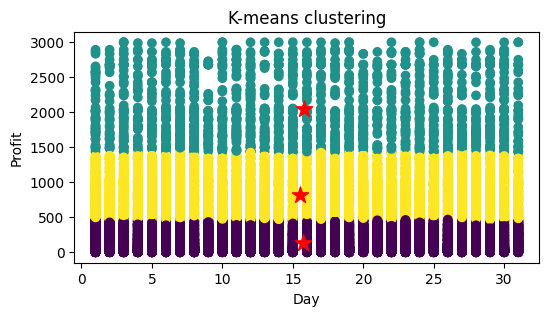

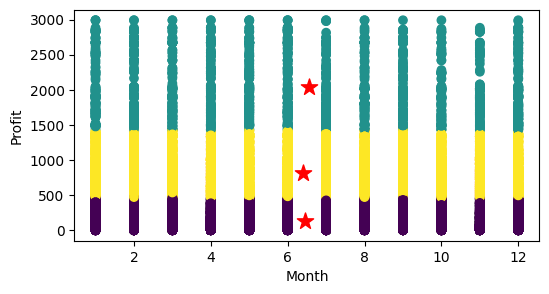

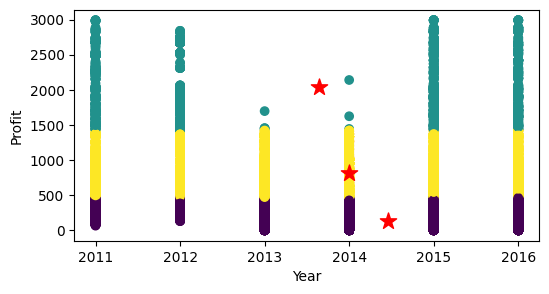

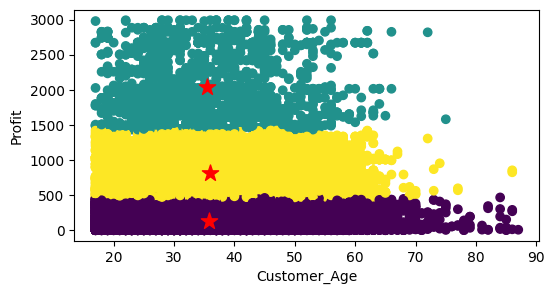

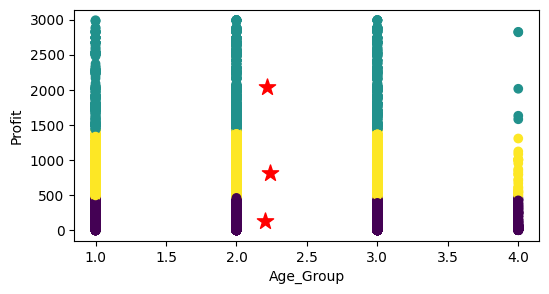

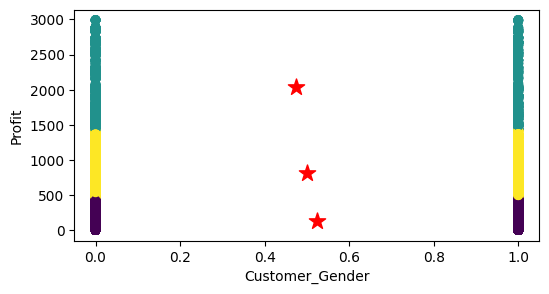

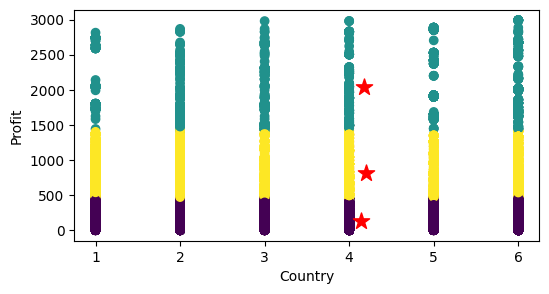

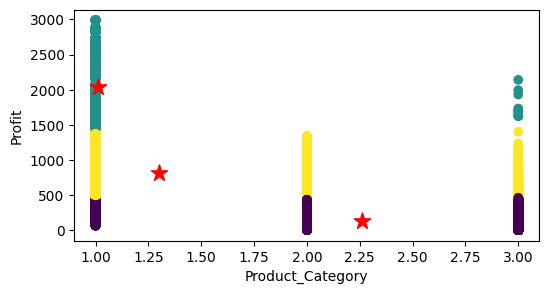

In [ ]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(df)
kmeans_labels = kmeans.labels_

for i in range(df.shape[1]-2):
  plt.figure(figsize = (6,3))
  plt.scatter(df.iloc[:,i], df.iloc[:,9], c = kmeans.labels_)
  plt.scatter(kmeans.cluster_centers_[:,i], kmeans.cluster_centers_[:,9], marker='*', s=150, c='red')
  plt.xlabel(df.columns[i])
  plt.ylabel('Profit')
  if i == 0:
    plt.title('K-means clustering')
  plt.show()

In [ ]:
clustering_report(df, kmeans.labels_)

Silhouette score: 0.7067662207613304 --- Варьируется от -1 до 1, лучше, когда больше
Calinski harabasz score: 144855.63120891436 --- Лучше, когда больше
Davies bouldin score: 0.4652136412187106 --- Лучше, когда меньше


DBSCAN

Количество кластеров: 4
Количество выбросов(синие точки): 3195


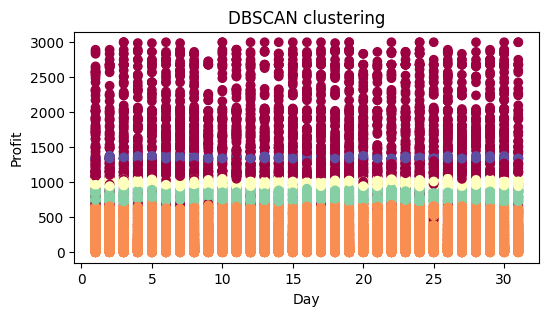

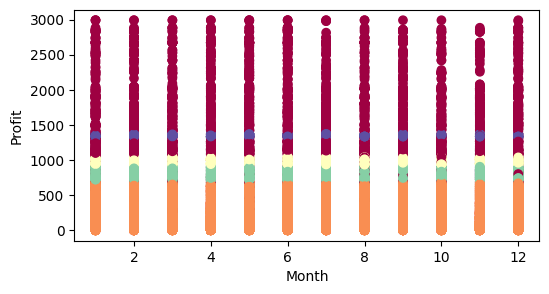

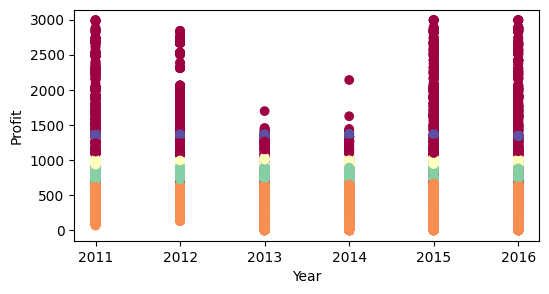

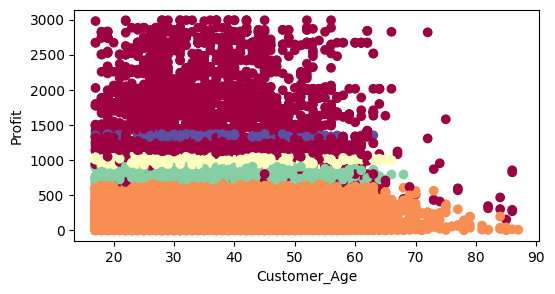

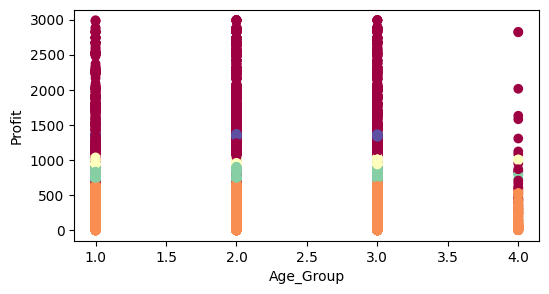

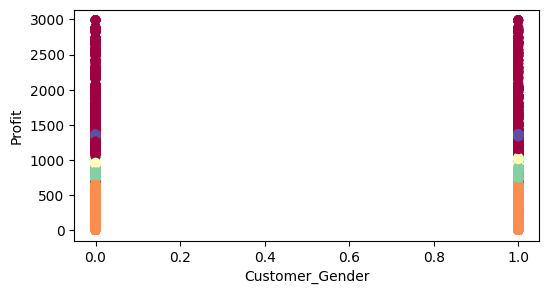

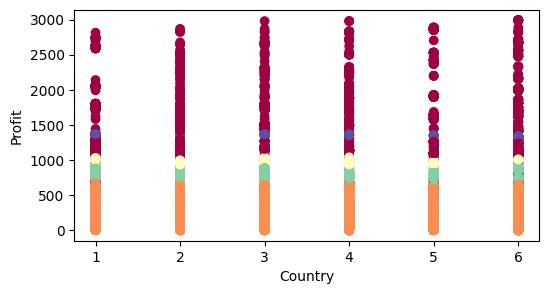

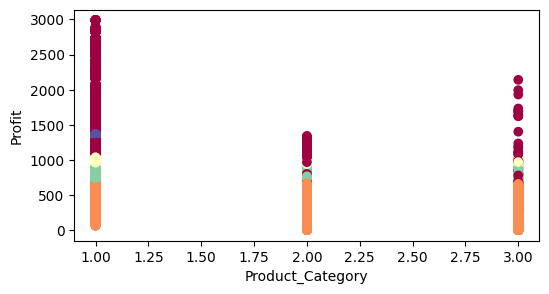

In [ ]:
dbscan = DBSCAN(eps= 25, min_samples= 350)
dbscan_labels = dbscan.fit_predict(df)

print(f'Количество кластеров: {len(set(dbscan_labels))-1}\nКоличество выбросов(синие точки): {list(dbscan_labels).count(-1)}')

for i in range(df.shape[1]-2):
  plt.figure(figsize = (6,3))
  plt.scatter(df.iloc[:,i], df.iloc[:,9], c = dbscan_labels, cmap = 'Spectral')
  plt.xlabel(df.columns[i])
  plt.ylabel('Profit')
  if i == 0:
    plt.title('DBSCAN clustering')
  plt.show()

In [ ]:
clustering_report(df, dbscan_labels)

Silhouette score: 0.5489072293462562 --- Варьируется от -1 до 1, лучше, когда больше
Calinski harabasz score: 43063.42944353688 --- Лучше, когда больше
Davies bouldin score: 1.0791739634851034 --- Лучше, когда меньше


По метрикам, а главное визуально, видно, что k-means более эффективно разделил данные. Полученные кластеры могут быть легко интерпритируемы.

2 ОБУЧЕНИЕ НА ДАННЫХ PCA

In [ ]:
X = df_scaled.drop('Profit', axis =1)
y = df_scaled['Profit']

In [ ]:
X_pca = df_pca_scaled.drop('Profit', axis =1)
y_pca = df_pca_scaled['Profit']

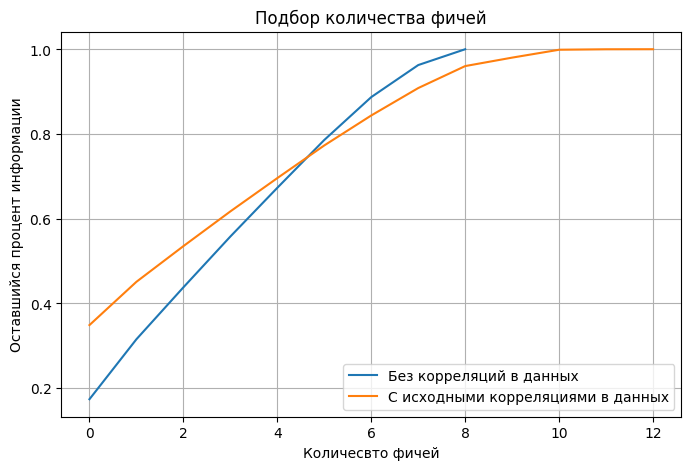

In [ ]:
pca = PCA().fit(X)
pca2 = PCA().fit(X_pca)

plt.figure(figsize=(8,5))

plt.plot(np.cumsum(pca.explained_variance_ratio_), label = 'Без корреляций в данных')
plt.plot(np.cumsum(pca2.explained_variance_ratio_), label ='C исходными корреляциями в данных')

plt.xlabel('Количесвто фичей')
plt.ylabel('Оставшийся процент информации')
plt.title('Подбор количества фичей')
plt.grid(True)
plt.legend()

plt.show()

Как видно из графика, для обучения моделей датасет можно сократить до 5 фичей с полнотой информации в 75%. Кстати, как и предполагалось, PCA смог убрать  "проблемные корреляции", о чём свидельствует пересечение с прямой очищенного датасета.

In [ ]:
pca = PCA(n_components=5)

X = pd.DataFrame(pca.fit_transform(X_pca))
y = y_pca

X_train, X_test, y_train, y_test = train_test_split(X, y)

2.1 Регрессия (угадываем Profit)

In [ ]:
rf = RandomForestRegressor(max_depth=20,
                           n_estimators = 1000)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

regression_report(y_test, y_pred)

MAE: 0.29174086887904216
MSE: 0.17644250780808668


Gradient Boosting Regressor

In [ ]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)

regression_report(y_test, y_pred)

MAE: 0.3196121030430378
MSE: 0.20409771227422177


Neural Network Regressor

In [ ]:
model_NN = tf.keras.Sequential([
    tf.keras.layers.Dense(units=10, activation='relu'),
    tf.keras.layers.Dense(units=20, activation='relu'),
    tf.keras.layers.Dense(units=15, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='relu'),
    tf.keras.layers.Dense(units=5, activation='relu'),
    tf.keras.layers.Dense(units=1, activation = 'relu')
])

model_NN.compile(optimizer='adam', loss='mse')

loss = model_NN.fit(X_train, y_train, epochs = 60)

Epoch 1/60
1157/1157 [==============================] - 14s 9ms/step - loss: 0.4232
Epoch 2/60
1157/1157 [==============================] - 6s 5ms/step - loss: 0.3948
Epoch 3/60
1157/1157 [==============================] - 5s 4ms/step - loss: 0.3938
Epoch 4/60
1157/1157 [==============================] - 6s 5ms/step - loss: 0.3913
Epoch 5/60
1157/1157 [==============================] - 5s 4ms/step - loss: 0.3905
Epoch 6/60
1157/1157 [==============================] - 4s 3ms/step - loss: 0.3908
Epoch 7/60
1157/1157 [==============================] - 6s 5ms/step - loss: 0.3889
Epoch 8/60
1157/1157 [==============================] - 4s 3ms/step - loss: 0.3895
Epoch 9/60
1157/1157 [==============================] - 5s 4ms/step - loss: 0.3880
Epoch 10/60
1157/1157 [==============================] - 6s 5ms/step - loss: 0.3890
Epoch 11/60
1157/1157 [==============================] - 5s 4ms/step - loss: 0.3882
Epoch 12/60
1157/1157 [==============================] - 4s 4ms/step - loss: 0.3873


386/386 [==============================] - 1s 2ms/step
MAE: 0.5249105852873147
MSE: 0.3745682517182133


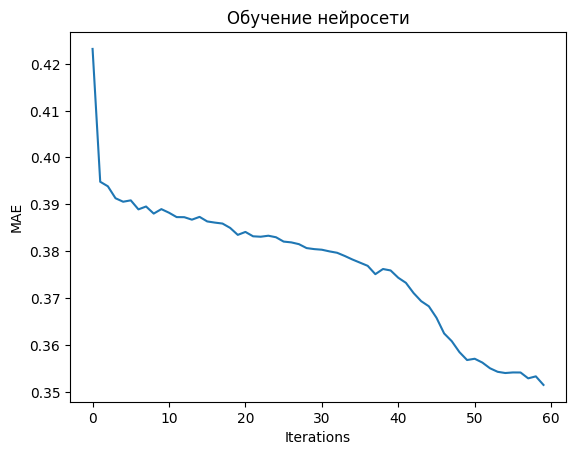

In [ ]:
y_pred = model_NN.predict(X_test)
regression_report(y_test, y_pred)

plt.plot(loss.history['loss'])
plt.title('Обучение нейросети')
plt.xlabel('Iterations')
plt.ylabel('MAE')
plt.show()

2.2 Классификация (угадываем Product Category)

In [ ]:
pca = PCA(n_components=5)

X_pca = df_pca_scaled.drop('Product_Category', axis = 1)
y_pca = df_pca_scaled['Product_Category']

X = pd.DataFrame(pca.fit_transform(X_pca))
y = y_pca

X_train, X_test, y_train, y_test = train_test_split(X, y)

Random Forest Classifier

Accuracy score: 0.7440427946182525
F-1 score: 0.7346876271575954


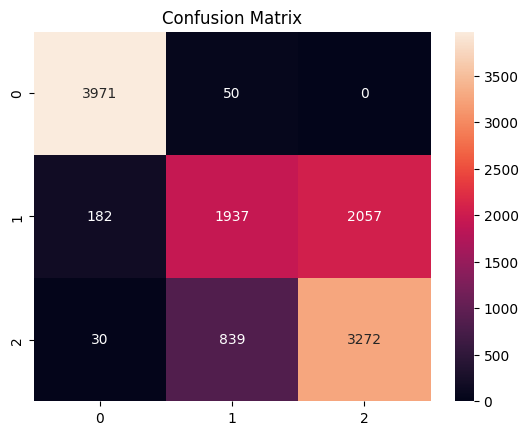

In [ ]:
rf = RandomForestClassifier(max_depth= 20,
                           n_estimators = 1000)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

classification_report(y_test, y_pred)

SVM Classifier

Accuracy score: 0.7386934673366834
F-1 score: 0.7340878913799098


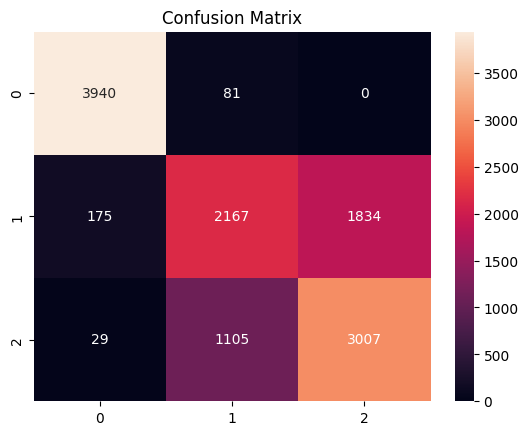

In [ ]:
svc = SVC()

svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

classification_report(y_test, y_pred)

Neural Network Classification

In [ ]:
model_nn = tf.keras.Sequential([
    keras.layers.Dense(10, activation=tf.nn.relu),
    keras.layers.Dense(20, activation=tf.nn.relu),
    keras.layers.Dense(15, activation=tf.nn.relu),
    keras.layers.Dense(8, activation=tf.nn.relu),
    keras.layers.Dense(4, activation=tf.nn.softmax)
])

loss = tf.keras.losses.SparseCategoricalCrossentropy()
model_nn.compile(optimizer = 'adam', loss = loss, metrics=['accuracy'])

history = model_nn.fit(X_test, y_test, epochs = 200)

Epoch 1/200
386/386 [==============================] - 3s 4ms/step - loss: 0.7224 - accuracy: 0.6358
Epoch 2/200
386/386 [==============================] - 1s 3ms/step - loss: 0.5026 - accuracy: 0.7176
Epoch 3/200
386/386 [==============================] - 1s 3ms/step - loss: 0.4934 - accuracy: 0.7255
Epoch 4/200
386/386 [==============================] - 1s 3ms/step - loss: 0.4881 - accuracy: 0.7299
Epoch 5/200
386/386 [==============================] - 2s 6ms/step - loss: 0.4851 - accuracy: 0.7294
Epoch 6/200
386/386 [==============================] - 2s 6ms/step - loss: 0.4833 - accuracy: 0.7338
Epoch 7/200
386/386 [==============================] - 1s 3ms/step - loss: 0.4814 - accuracy: 0.7319
Epoch 8/200
386/386 [==============================] - 1s 3ms/step - loss: 0.4799 - accuracy: 0.7336
Epoch 9/200
386/386 [==============================] - 1s 3ms/step - loss: 0.4789 - accuracy: 0.7367
Epoch 10/200
386/386 [==============================] - 1s 3ms/step - loss: 0.4773 - accura

386/386 [==============================] - 1s 3ms/step
Accuracy score: 0.7487437185929648
F-1 score: 0.7433930390081014


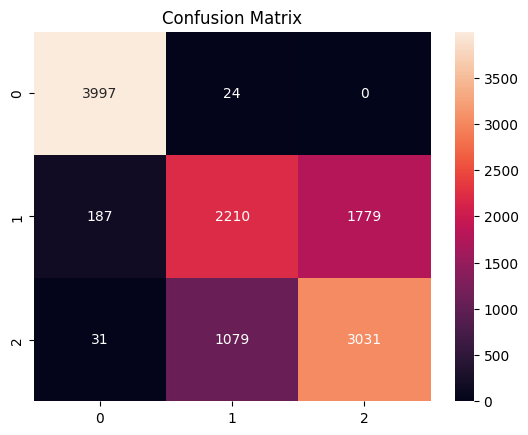

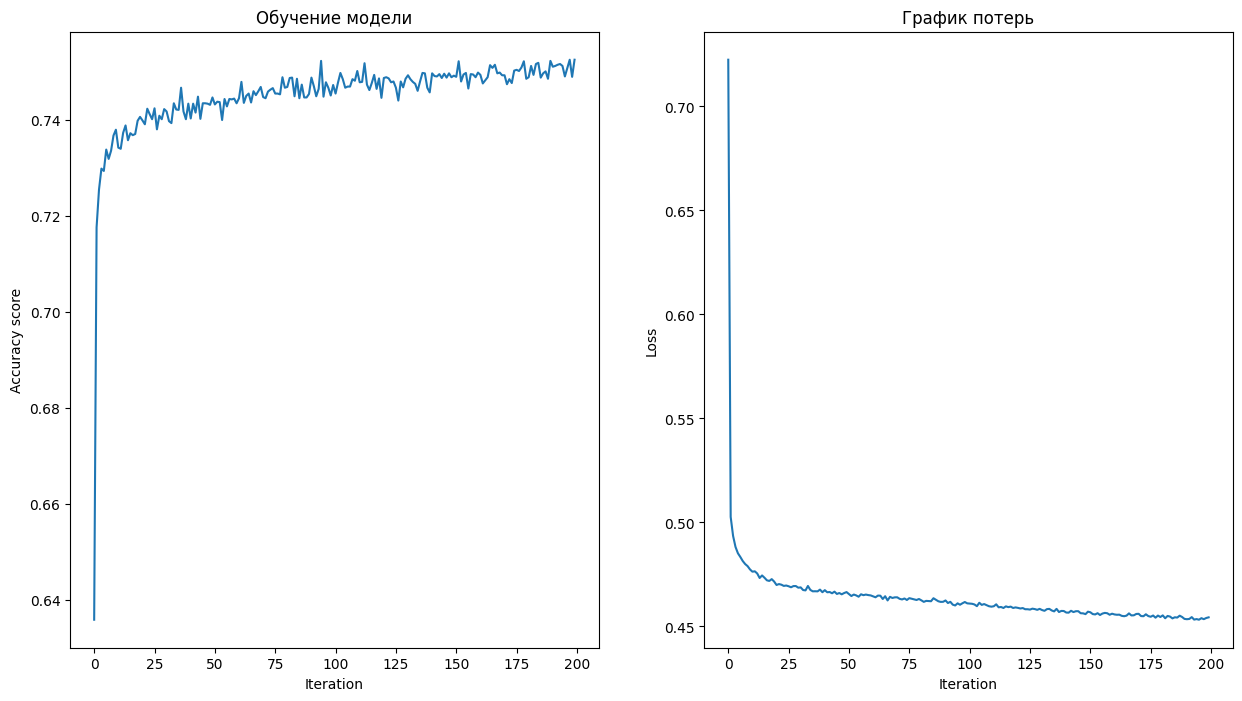

In [ ]:
y_pred = model_nn.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

classification_report(y_test, y_pred)

plt.figure(figsize = (15, 8))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"])
plt.xlabel('Iteration')
plt.ylabel('Accuracy score')
plt.title('Обучение модели')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('График потерь')

plt.show()

2.3 Кластеризация PCA

K-means

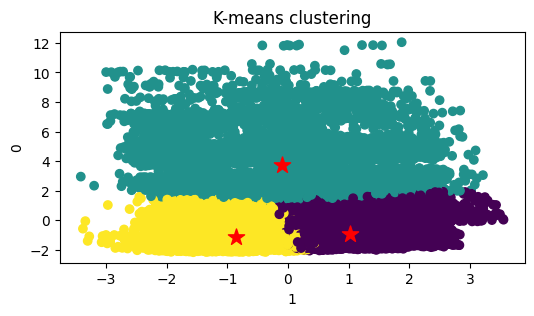

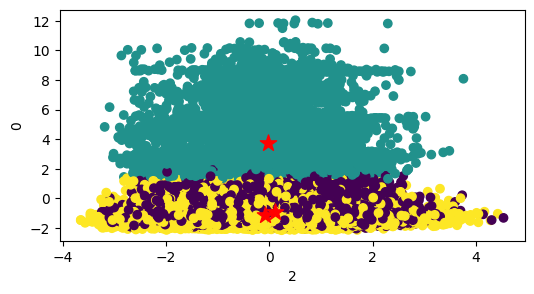

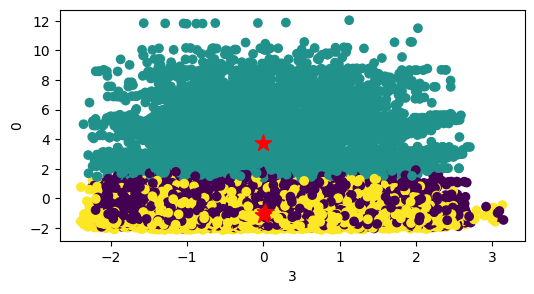

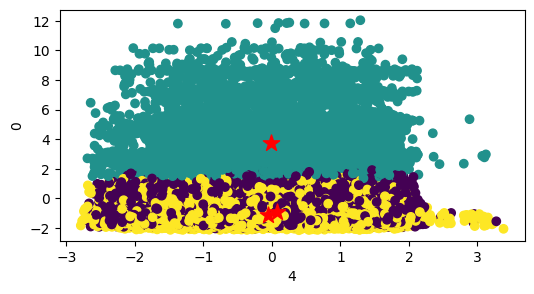

In [ ]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(X)
kmeans_labels = kmeans.labels_

for i in range(1, X.shape[1]):
  plt.figure(figsize = (6,3))
  plt.scatter(X.iloc[:,i], X.iloc[:,0], c = kmeans.labels_)
  plt.scatter(kmeans.cluster_centers_[:,i], kmeans.cluster_centers_[:,0], marker='*', s=150, c='red')
  plt.xlabel(X.columns[i])
  plt.ylabel(0)
  if i == 1:
    plt.title('K-means clustering')
  plt.show()

In [ ]:
clustering_report(X, kmeans_labels)

Silhouette score: 0.21098956161221463 --- Варьируется от -1 до 1, лучше, когда больше
Calinski harabasz score: 23681.560822357813 --- Лучше, когда больше
Davies bouldin score: 1.6494337833886021 --- Лучше, когда меньше


Количество кластеров: 3
Количество выбросов(синие точки): 12060


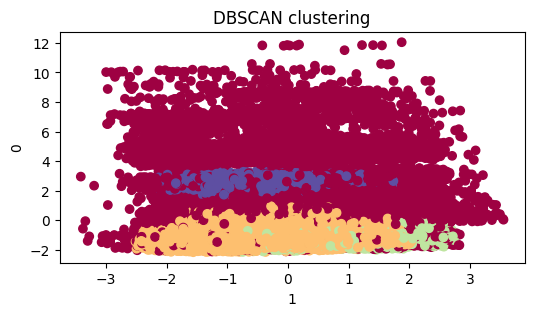

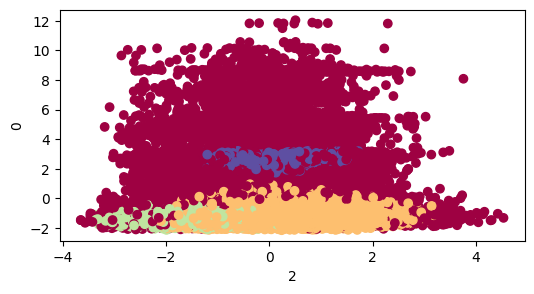

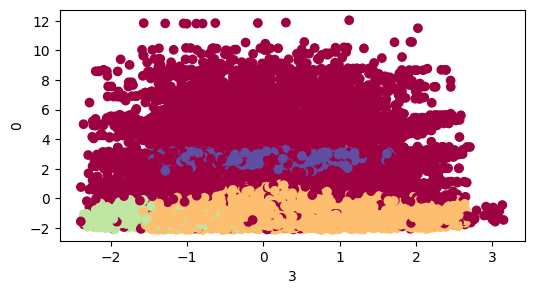

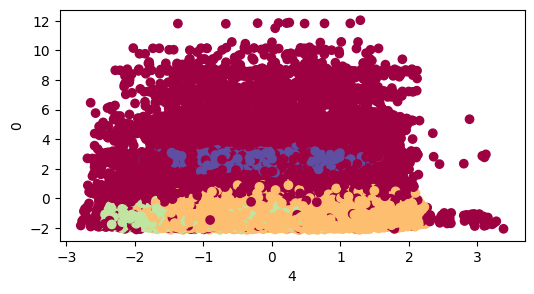

In [ ]:
dbscan = DBSCAN(eps= 0.75, min_samples= 80)
dbscan_labels = dbscan.fit_predict(X)

print(f'Количество кластеров: {len(set(dbscan_labels))-1}\nКоличество выбросов(синие точки): {list(dbscan_labels).count(-1)}')

for i in range(1, X.shape[1]):
  plt.figure(figsize = (6,3))
  plt.scatter(X.iloc[:,i], X.iloc[:,0], c = dbscan_labels, cmap = 'Spectral')
  plt.xlabel(X.columns[i])
  plt.ylabel(0)
  if i == 1:
    plt.title('DBSCAN clustering')
  plt.show()

In [ ]:
clustering_report(X, dbscan_labels)

Silhouette score: 0.13391881416566737 --- Варьируется от -1 до 1, лучше, когда больше
Calinski harabasz score: 10335.384424504531 --- Лучше, когда больше
Davies bouldin score: 3.716533727337505 --- Лучше, когда меньше


У меня проблема с интерпритацией этих данных. Сколько бы я не крутил параметры, всё равно получается каша какая-то. В целом, что-то вычленить можно, но не знаю, как интерпритировать новый PCA фичи.
Есть ощущение, что K-means справился чуть лучше, но всё равно не очень. Метрики это, в целом, подтверждают.

3 Обучение на данных LDA

In [ ]:
X = df_pca_scaled.drop('Product_Category', axis =1)
y = df_pca_scaled['Product_Category']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
lda = LDA(n_components = 2)

X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

3.1 Регрессия (угадываем Profit)

Обучить модели регрессии с помощью LDA не получается, так не соблюдается условие min(n_features, n_classes - 1). Поэтому начнём с классификации.

3.2 Классификация (угадываем Product_Category)

Random Forest Classifier

Accuracy score: 0.9891392446101475
F-1 score: 0.9891382742599124


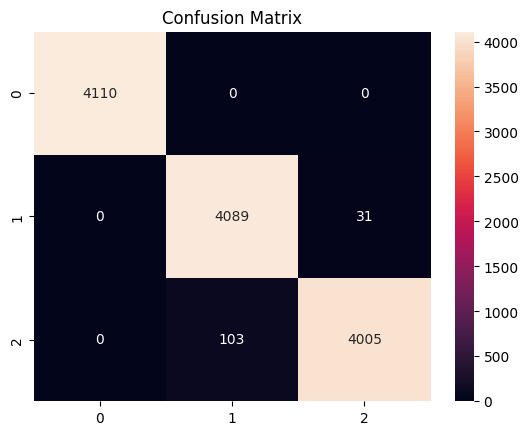

In [ ]:
rf = RandomForestClassifier(max_depth= 20,
                           n_estimators = 1000)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

classification_report(y_test, y_pred)

SVM Classifier

Accuracy score: 0.8651321121737721
F-1 score: 0.8610528330285527


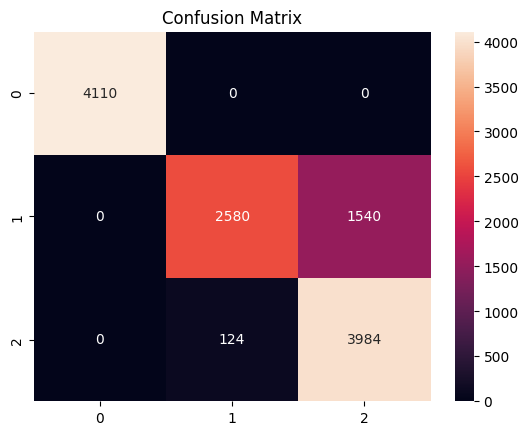

In [ ]:
svc = SVC()

svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

classification_report(y_test, y_pred)

Neural Network Classification

In [ ]:
model_nn = tf.keras.Sequential([
    keras.layers.Dense(10, activation=tf.nn.relu),
    keras.layers.Dense(20, activation=tf.nn.relu),
    keras.layers.Dense(15, activation=tf.nn.relu),
    keras.layers.Dense(8, activation=tf.nn.relu),
    keras.layers.Dense(4, activation=tf.nn.softmax)
])

loss = tf.keras.losses.SparseCategoricalCrossentropy()
model_nn.compile(optimizer = 'adam', loss = loss, metrics=['accuracy'])

history = model_nn.fit(X_test, y_test, epochs = 200)

Epoch 1/200
386/386 [==============================] - 10s 7ms/step - loss: 0.6427 - accuracy: 0.6727
Epoch 2/200
386/386 [==============================] - 3s 7ms/step - loss: 0.4335 - accuracy: 0.7511
Epoch 3/200
386/386 [==============================] - 3s 8ms/step - loss: 0.3966 - accuracy: 0.7801
Epoch 4/200
386/386 [==============================] - 5s 13ms/step - loss: 0.3698 - accuracy: 0.7980
Epoch 5/200
386/386 [==============================] - 3s 8ms/step - loss: 0.3545 - accuracy: 0.8065
Epoch 6/200
386/386 [==============================] - 3s 7ms/step - loss: 0.3393 - accuracy: 0.8136
Epoch 7/200
386/386 [==============================] - 2s 6ms/step - loss: 0.3097 - accuracy: 0.8508
Epoch 8/200
386/386 [==============================] - 2s 6ms/step - loss: 0.2933 - accuracy: 0.8640
Epoch 9/200
386/386 [==============================] - 4s 10ms/step - loss: 0.2853 - accuracy: 0.8702
Epoch 10/200
386/386 [==============================] - 3s 8ms/step - loss: 0.2790 - acc

386/386 [==============================] - 1s 2ms/step
Accuracy score: 0.9672556330037283
F-1 score: 0.9672536692110011


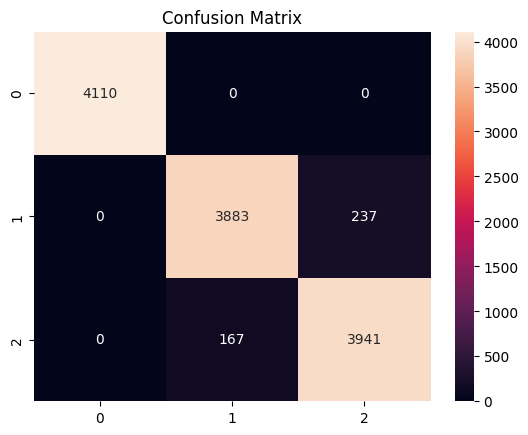

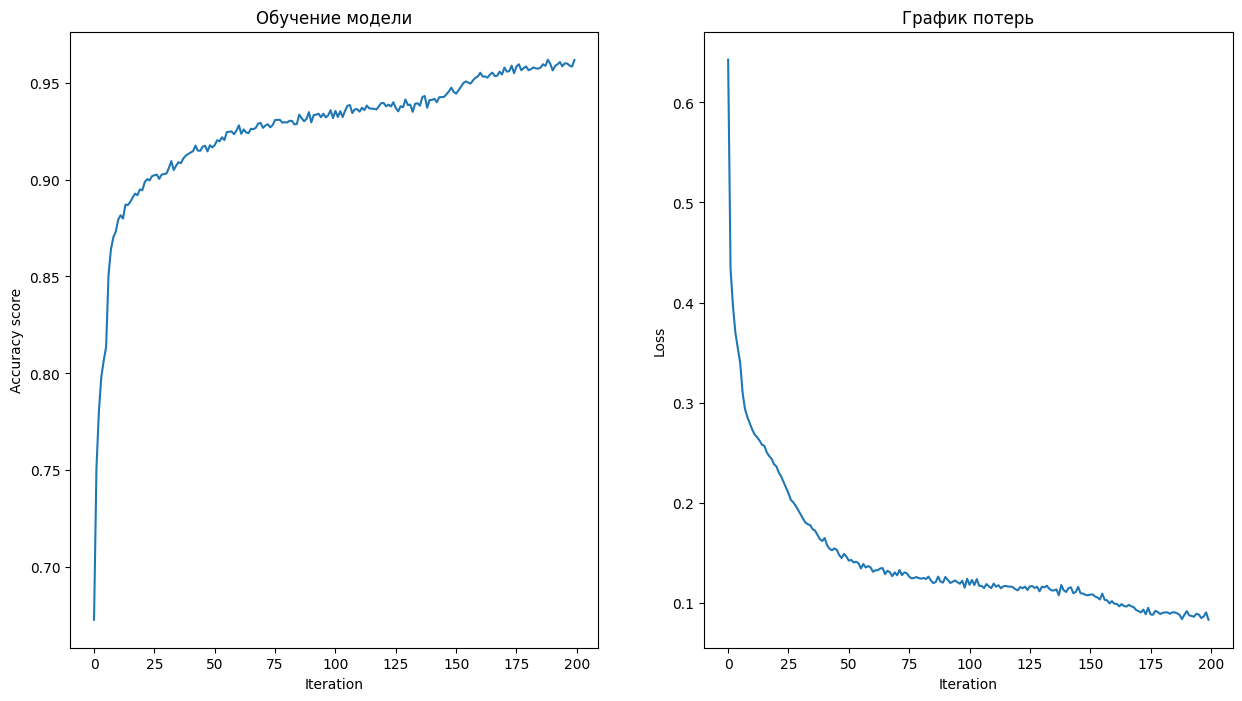

In [ ]:
y_pred = model_nn.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

classification_report(y_test, y_pred)

plt.figure(figsize = (15, 8))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"])
plt.xlabel('Iteration')
plt.ylabel('Accuracy score')
plt.title('Обучение модели')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('График потерь')

plt.show()

3.3 Кластеризация LDA

K-means

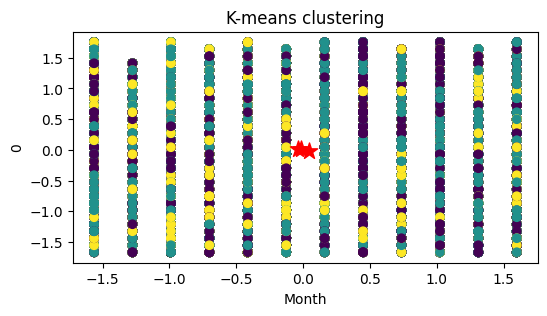

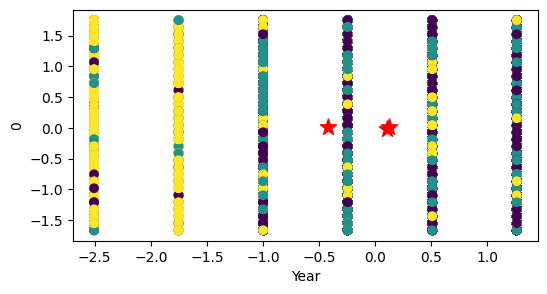

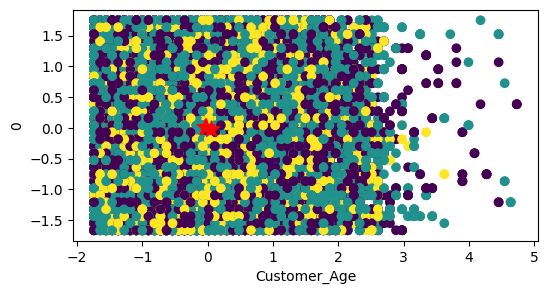

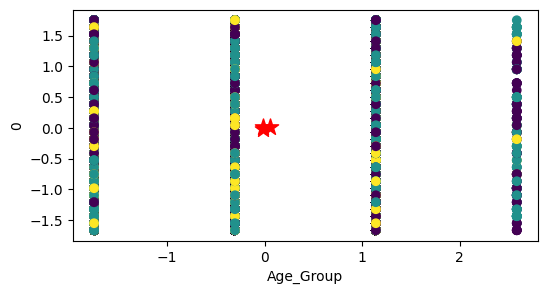

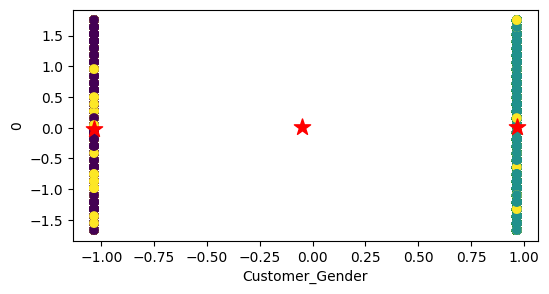

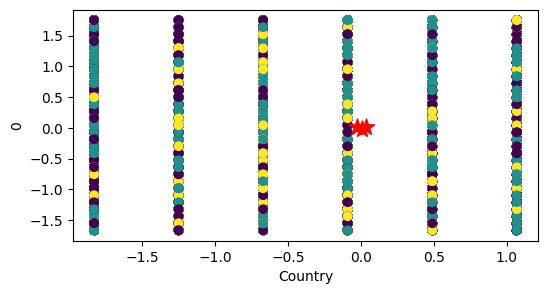

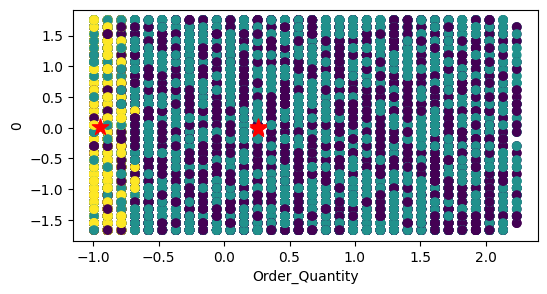

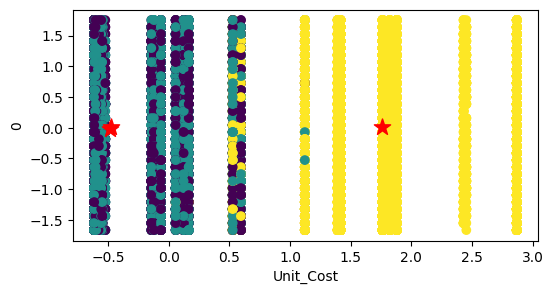

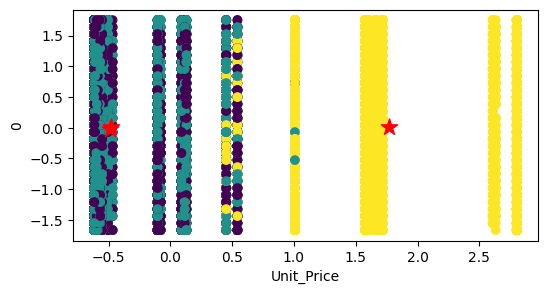

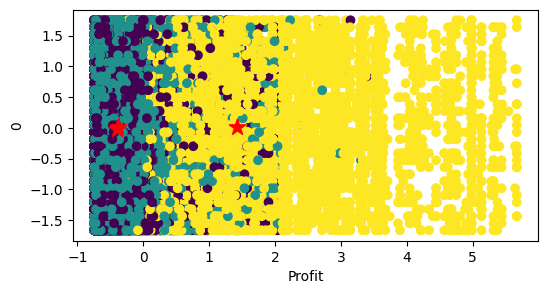

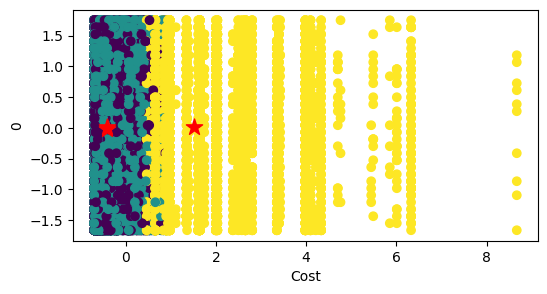

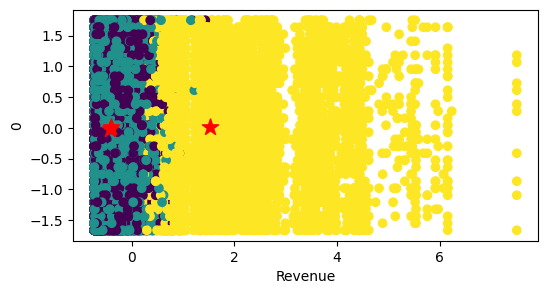

In [ ]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(X)
kmeans_labels = kmeans.labels_

for i in range(1, X.shape[1]):
  plt.figure(figsize = (6,3))
  plt.scatter(X.iloc[:,i], X.iloc[:,0], c = kmeans.labels_)
  plt.scatter(kmeans.cluster_centers_[:,i], kmeans.cluster_centers_[:,0], marker='*', s=150, c='red')
  plt.xlabel(X.columns[i])
  plt.ylabel(0)
  if i == 1:
    plt.title('K-means clustering')
  plt.show()

In [ ]:
clustering_report(X, kmeans_labels)

Silhouette score: 0.1471315361102688 --- Варьируется от -1 до 1, лучше, когда больше
Calinski harabasz score: 13527.322958836712 --- Лучше, когда больше
Davies bouldin score: 2.187210619277861 --- Лучше, когда меньше


Количество кластеров: 3
Количество выбросов(синие точки): 2502


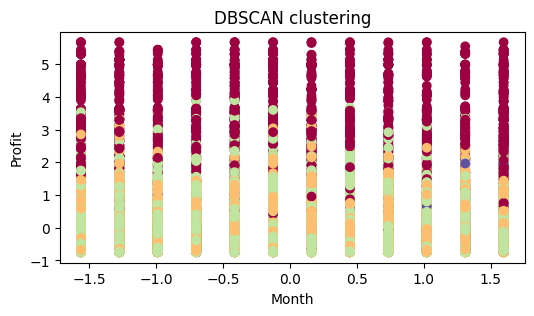

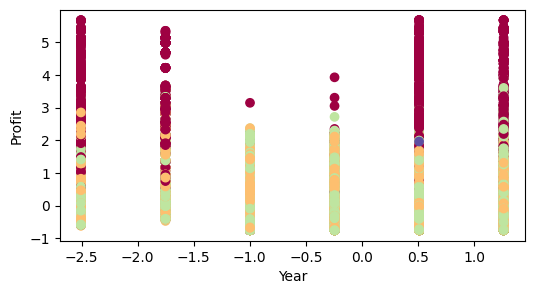

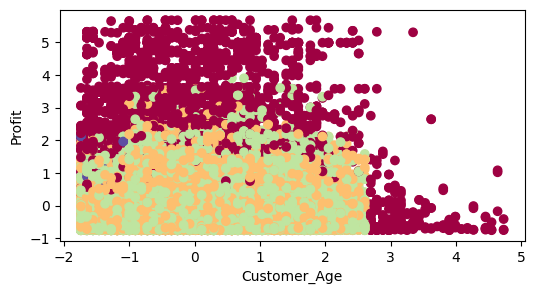

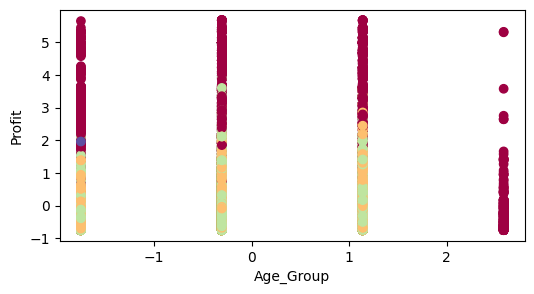

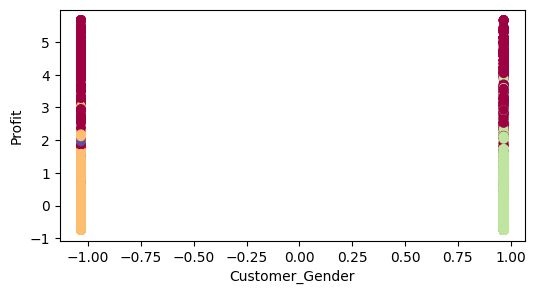

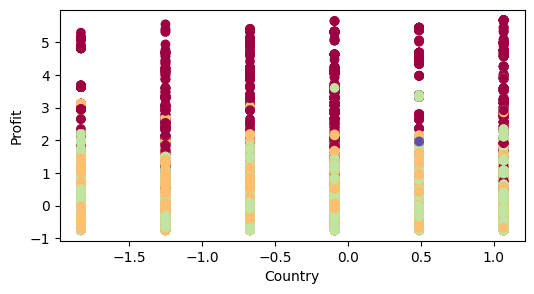

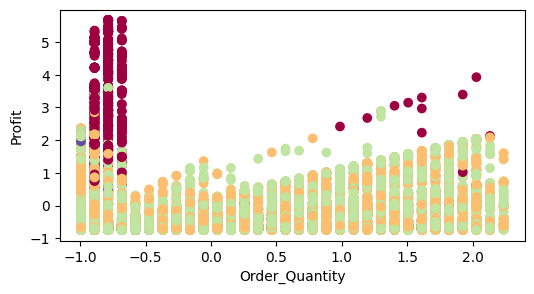

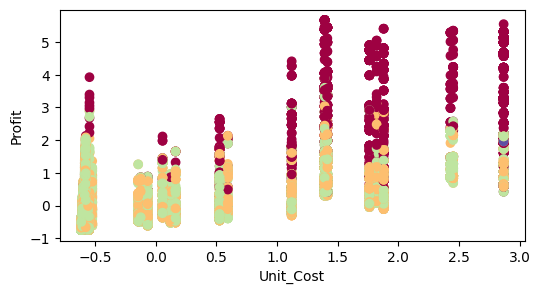

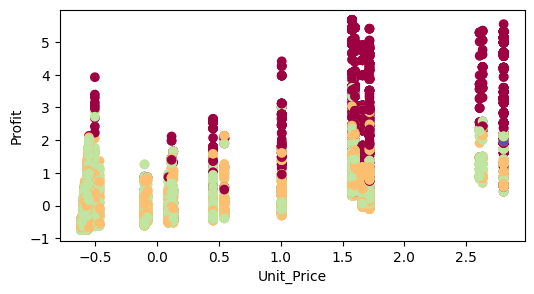

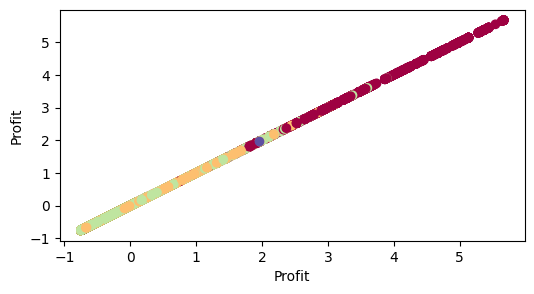

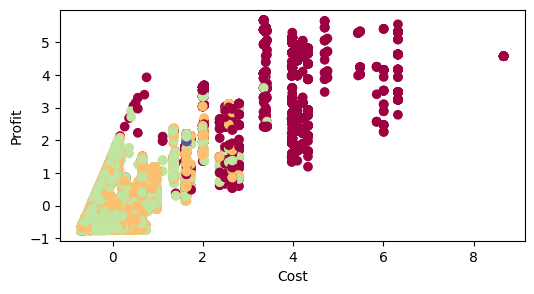

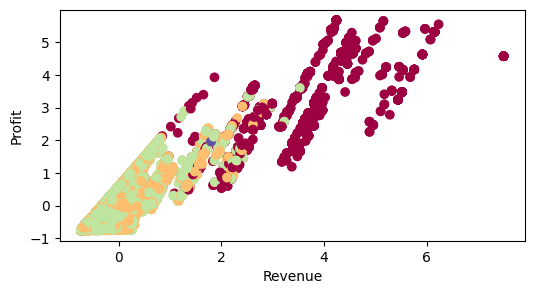

In [ ]:
dbscan = DBSCAN(eps= 1.85, min_samples= 50)
dbscan_labels = dbscan.fit_predict(X)

print(f'Количество кластеров: {len(set(dbscan_labels))-1}\nКоличество выбросов(синие точки): {list(dbscan_labels).count(-1)}')

for i in range(1, X.shape[1]):
  plt.figure(figsize = (6,3))
  plt.scatter(X.iloc[:,i], X.iloc[:,10], c = dbscan_labels, cmap = 'Spectral')
  plt.xlabel(X.columns[i])
  plt.ylabel(X.columns[10])
  if i == 1:
    plt.title('DBSCAN clustering')
  plt.show()

In [ ]:
clustering_report(X, dbscan_labels)

Silhouette score: 0.062839293961467 --- Варьируется от -1 до 1, лучше, когда больше
Calinski harabasz score: 4121.858673024249 --- Лучше, когда больше
Davies bouldin score: 2.2151834732765954 --- Лучше, когда меньше


4 ВЫВОДЫ

In [ ]:
print(mae_list)
print(mse_list)

print(accuracy_list)
print(f1_list)

print(sil_score)
print(cal_har_score)
print(bould_score)

[0.3979248381707405, 0.4407226001029467, 0.6491774060720543, 0.29174086887904216, 0.3196121030430378, 0.5249105852873147]
[0.38663056121077843, 0.43682981616891176, 0.6088865910589689, 0.1764425078080866, 0.20409771227422177, 0.3745682517182133]
[0.8875020262603339, 0.6959798994974874, 0.8209596368941482, 0.7440427946182525, 0.7386934673366834, 0.7487437185929648, 0.9891392446101475, 0.8651321121737721, 0.9672556330037283]
[0.8874233455663422, 0.6936222605405142, 0.8208217999971538, 0.7346876271575954, 0.7340878913799098, 0.7433930390081014, 0.9891382742599124, 0.8610528330285527, 0.9672536692110011]
[0.7067662207613304, 0.5489072293462562, 0.21098956161221463, 0.13391881416566737, 0.1471315361102688, 0.062839293961467]
[144855.63120891436, 43063.42944353688, 23681.560822357813, 10335.384424504531, 13527.322958836712, 4121.858673024249]
[0.4652136412187106, 1.0791739634851034, 1.6494337833886021, 3.716533727337505, 2.187210619277861, 2.2151834732765954]


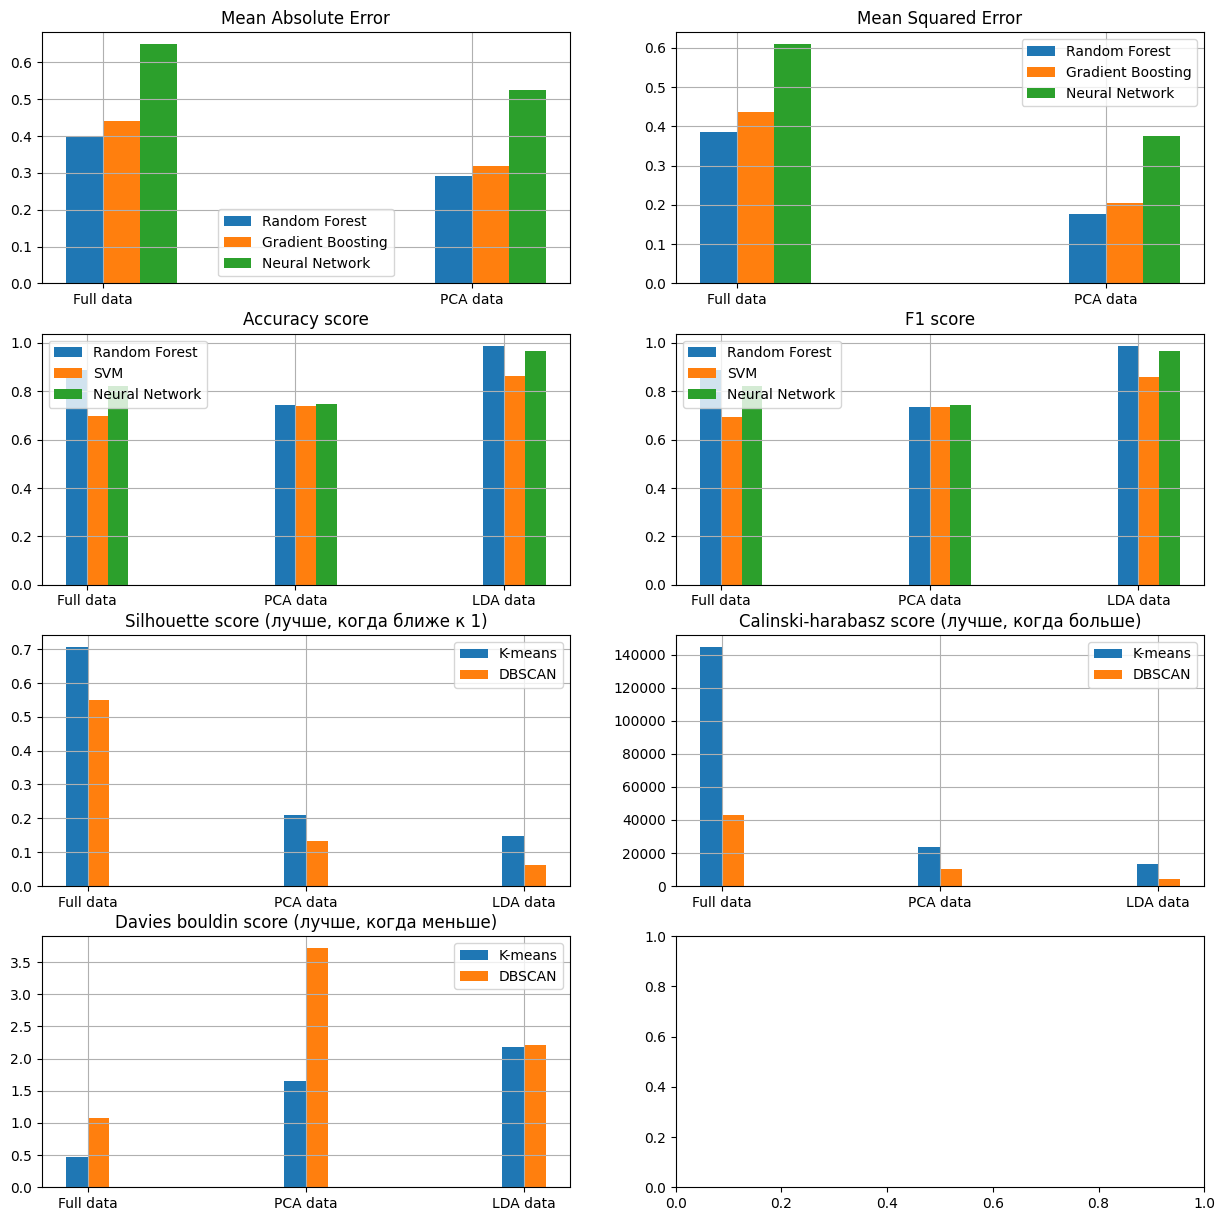

In [ ]:
fig, axs = plt.subplots(4, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
width =0.1

names = ['Full data', 'PCA data']
rf = [mae_list[0], mae_list[3]]
grb = [mae_list[1], mae_list[4]]
nn = [mae_list[2], mae_list[5]]
x = np.arange(len(names))

axs[0, 0].set_title('Mean Absolute Error')
rects1 = axs[0, 0].bar(x - width/2, rf, width, label='Random Forest')
rects2 = axs[0, 0].bar(x + width/2, grb, width, label='Gradient Boosting')
rects3 = axs[0, 0].bar(x + 0.15, nn, width, label='Neural Network')
axs[0, 0].set_xticks(x)
axs[0, 0].set_xticklabels(names)
axs[0, 0].legend()
axs[0, 0].grid()

names = ['Full data', 'PCA data']
rf = [mse_list[0], mse_list[3]]
grb = [mse_list[1], mse_list[4]]
nn = [mse_list[2], mse_list[5]]
x = np.arange(len(names))

axs[0, 1].set_title('Mean Squared Error')
rects1 = axs[0, 1].bar(x - width/2, rf, width, label='Random Forest')
rects2 = axs[0, 1].bar(x + width/2, grb, width, label='Gradient Boosting')
rects3 = axs[0, 1].bar(x + 0.15, nn, width, label='Neural Network')
axs[0, 1].set_xticks(x)
axs[0, 1].set_xticklabels(names)
axs[0, 1].legend()
axs[0, 1].grid()

names = ['Full data', 'PCA data', 'LDA data']
rf = [accuracy_list[0], accuracy_list[3], accuracy_list[6]]
svm = [accuracy_list[1], accuracy_list[4], accuracy_list[7]]
nn = [accuracy_list[2], accuracy_list[5], accuracy_list[8]]
x = np.arange(len(names))

axs[1, 0].set_title('Accuracy score')
rects1 = axs[1, 0].bar(x - width/2, rf, width, label='Random Forest')
rects2 = axs[1, 0].bar(x + width/2, svm, width, label='SVM')
rects3 = axs[1, 0].bar(x + 0.15, nn, width, label='Neural Network')
axs[1, 0].set_xticks(x)
axs[1, 0].set_xticklabels(names)
axs[1, 0].legend()
axs[1, 0].grid()

rf = [f1_list[0], f1_list[3], f1_list[6]]
svm = [f1_list[1], f1_list[4], f1_list[7]]
nn = [f1_list[2], f1_list[5], f1_list[8]]

axs[1, 1].set_title('F1 score')
rects1 = axs[1, 1].bar(x - width/2, rf, width, label='Random Forest')
rects2 = axs[1, 1].bar(x + width/2, svm, width, label='SVM')
rects3 = axs[1, 1].bar(x + 0.15, nn, width, label='Neural Network')
axs[1, 1].set_xticks(x)
axs[1, 1].set_xticklabels(names)
axs[1, 1].legend()
axs[1, 1].grid()

kmeans = [sil_score[0], sil_score[2], sil_score[4]]
dbscan = [sil_score[1], sil_score[3], sil_score[5]]

axs[2, 0].set_title('Silhouette score (лучше, когда ближе к 1)')
rects1 = axs[2, 0].bar(x - width/2, kmeans, width, label='K-means')
rects2 = axs[2, 0].bar(x + width/2, dbscan, width, label='DBSCAN')
axs[2, 0].set_xticks(x)
axs[2, 0].set_xticklabels(names)
axs[2, 0].legend()
axs[2, 0].grid()

kmeans = [cal_har_score[0], cal_har_score[2], cal_har_score[4]]
dbscan = [cal_har_score[1], cal_har_score[3], cal_har_score[5]]

axs[2, 1].set_title('Calinski-harabasz score (лучше, когда больше)')
rects1 = axs[2, 1].bar(x - width/2, kmeans, width, label='K-means')
rects2 = axs[2, 1].bar(x + width/2, dbscan, width, label='DBSCAN')
axs[2, 1].set_xticks(x)
axs[2, 1].set_xticklabels(names)
axs[2, 1].legend()
axs[2, 1].grid()

kmeans = [bould_score[0], bould_score[2], bould_score[4]]
dbscan = [bould_score[1], bould_score[3], bould_score[5]]

axs[3, 0].set_title('Davies bouldin score (лучше, когда меньше)')
rects1 = axs[3, 0].bar(x - width/2, kmeans, width, label='K-means')
rects2 = axs[3, 0].bar(x + width/2, dbscan, width, label='DBSCAN')
axs[3, 0].set_xticks(x)
axs[3, 0].set_xticklabels(names)
axs[3, 0].legend()
axs[3, 0].grid()

Регрессия

С регрессией лучше всего справились модели после **PCA**. LDA обучить не получилось. У PCA моделей лучше MAE и MSE. Лучшая модель была Random Forest.

Классификация

С классификацией лучше всего справились модели после **LDA**. Например у RF и NN, точность в районе 98%. PCA справился хуже.

Кластеризация

С задачей кластеризации снижение размерности, судя по метрикам, справилось плохо. Так, все основные показатели (+ визуально) лучше на моделях, обученных на полных данных.